In [1]:
import numpy as np
import seaborn as sns;
from matplotlib import pyplot as plt
import itertools
import keras

from pycpd import RigidRegistration
from pycpd import AffineRegistration
from pycpd import DeformableRegistration
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs

In [2]:
def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R



def generate_gaussian_parity(n_samples, centers=None, class_label=None,
    cluster_std=0.25, angle_params=None, random_state=None):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y

In [3]:
X1, y1 = generate_gaussian_parity(1000)

Text(0.5, 1.0, 'XOR')

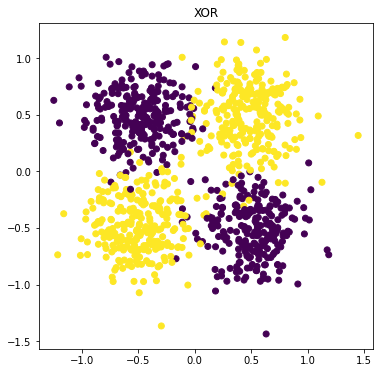

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.title("XOR")

In [35]:
def shear_dist(X, i, j, a):
    _,d = np.shape(X)
    
    #shear
    I = np.identity(d)
    I[i, j] = a
        
    X = X @ I
    
    return X

Text(0.5, 1.0, 'S_XOR')

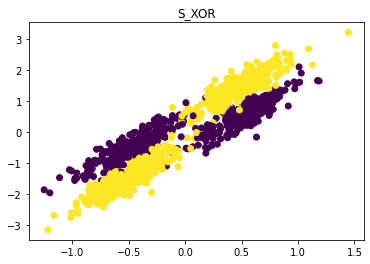

In [36]:
X2 = shear_dist(X1, 0, 1, 2)

plt.scatter(X2[:,0], X2[:,1], c=y1)
plt.title("S_XOR")

Text(0.5, 1.0, 'S_XOR')

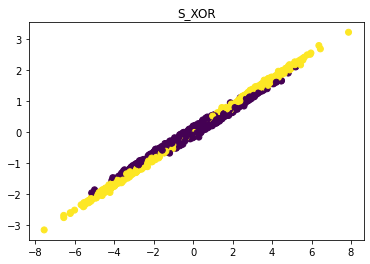

In [39]:
X3 = shear_dist(X2, 1, 0, 2)

plt.scatter(X3[:,0], X3[:,1], c=y1)
plt.title("S_XOR")

In [45]:
def make_2DGaussSSXOR(n_samples):
    n = int(n_samples / 4)
    std = 0.25
    
    c = np.array(list(itertools.product([0.5, -0.5], repeat=2)))
    z = np.full(shape=2, fill_value=n)

    X1,_ = make_blobs(n_samples=z, n_features=2, centers=c[[0,3], :], cluster_std=std)
    X2,_ = make_blobs(n_samples=z, n_features=2, centers=c[[1,2], :], cluster_std=std)
    y1 = np.ones(n*2)
    y2 = np.zeros(n*2)
    
    X1 = shear_dist(X1, 0, 1, 2)
    X2 = shear_dist(X2, 1, 0, -2)

    X = np.concatenate((X1, X2))
    y = np.concatenate((y1, y2))

    return X,y

Text(0.5, 1.0, 'SS_XOR')

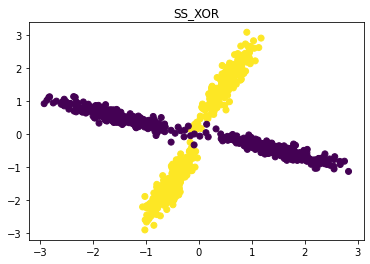

In [46]:
X5, y5 = make_2DGaussSXOR(1000);

plt.scatter(X5[:,0], X5[:,1], c=y5)
plt.title("SS_XOR")

In [60]:
def make_2DGaussSSXOR(n_samples):
    n = int(n_samples / 4)
    std = 0.25
    
    c = np.array(list(itertools.product([0.5, -0.5], repeat=2)))

    X1,_ = make_blobs(n_samples=n, n_features=2, centers=c[[0], :], cluster_std=std)
    X2,_ = make_blobs(n_samples=n, n_features=2, centers=c[[1], :], cluster_std=std)
    X3,_ = make_blobs(n_samples=n, n_features=2, centers=c[[2], :], cluster_std=std)
    X4,_ = make_blobs(n_samples=n, n_features=2, centers=c[[3], :], cluster_std=std)
    
    y1 = np.ones(n)
    y2 = np.zeros(n)
    
    X1 = shear_dist(X1, 0, 1, 2)
    X2 = shear_dist(X2, 0, 1, -2)

    X = np.concatenate((X1, X2, X3, X4))
    y = np.concatenate((y1, y2, y2, y1))

    return X,y

Text(0.5, 1.0, 'SS_XOR')

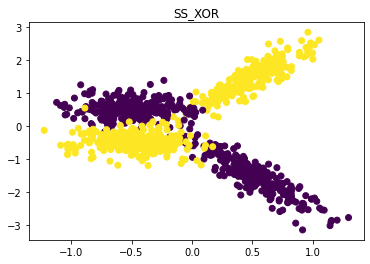

In [59]:
X6, y6 = make_2DGaussSSXOR(1000);

plt.scatter(X6[:,0], X6[:,1], c=y6)
plt.title("SS_XOR")